In [54]:
# Carga de librerias
# ------------------
# Librerias de uso general
import holidays
from google.cloud import storage

# Manejo de datos
import numpy as np
import pandas as pd

import kagglehub
import shutil
import os

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Estadística y series temporales
from statsmodels.tsa.seasonal import seasonal_decompose

#Cargar las librerías para Arima
import statsmodels.tsa.api as tsa # Módulo específico para series de tiempo
from statsmodels.graphics.tsaplots import plot_acf # Para dibujar el correlograma total - ACF
from statsmodels.graphics.tsaplots import plot_pacf # Para dibujar el correlograma parcial - PACF
sns.set()

# Se importan las funciones
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [55]:
# Descargar el archivo del bucket in GCP
# https://storage.cloud.google.com/amico-umedellin/

# Datos con corte a Abril usar: "costs.csv"
# Datos con corte a 18 de Mayo usar: "costs_20250518.csv"

#data_file = "costs_20250518.csv"

#!gsutil cp gs://amico-umedellin/{data_file} ./Users/angeleduardogamarrarios/Repositorio_UDEM/MLops_AMICO/data/costs.csv
df = pd.read_csv('/Users/angeleduardogamarrarios/Repositorio_UDEM/MLops_AMICO/data/costs.csv')
df.head()

,Service,Relational Database Service($),EC2-Instances($),FSx($),Elastic File System($),EC2-Other($),CloudWatch($),S3($),Elastic Load Balancing($),Backup($),Key Management Service($),DataSync($),Secrets Manager($),Resilience Hub($),Total costs($)
0,Service total,34131.482733,23531.788153,5152.073356,2830.548352,2132.939335,1543.902136,778.604880,758.963353,530.170434,91.476443,34.06381,0.178930,0.0,71516.191916
1,2024-06-01,31.851525,4.612654,12.472440,1.789663,0.611443,0.036701,1.156349,2.160000,0.281071,0.234161,NaN,0.000255,0.0,55.206262
2,2024-06-02,61.039787,NaN,12.460864,1.789663,0.322181,0.016653,1.126354,2.160000,0.281071,0.235058,NaN,0.000295,NaN,79.431926
3,2024-06-03,71.416393,63.161250,12.654853,1.790544,5.613880,0.429317,1.119325,2.160042,0.281071,0.240077,NaN,0.000225,NaN,158.866978
4,2024-06-04,54.833184,68.402379,12.658942,1.791199,5.682819,0.459109,1.116106,2.160139,0.281314,0.238019,NaN,0.000225,NaN,147.623435


In [56]:
#Revisando estructura de los datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Service                         352 non-null    object 
 1   Relational Database Service($)  352 non-null    float64
 2   EC2-Instances($)                330 non-null    float64
 3   FSx($)                          352 non-null    float64
 4   Elastic File System($)          352 non-null    float64
 5   EC2-Other($)                    352 non-null    float64
 6   CloudWatch($)                   352 non-null    float64
 7   S3($)                           352 non-null    float64
 8   Elastic Load Balancing($)       352 non-null    float64
 9   Backup($)                       351 non-null    float64
 10  Key Management Service($)       352 non-null    float64
 11  DataSync($)                     120 non-null    float64
 12  Secrets Manager($)              350 

In [57]:
column_mapper = {
    'Service': 'fecha',
    'Relational Database Service($)': 'rds',
    'EC2-Instances($)': 'ec2',
    'FSx($)': 'fsx',
    'Elastic File System($)': 'efs',
    'EC2-Other($)': 'ec2_other',
    'CloudWatch($)': 'cloudwatch',
    'Elastic Load Balancing($)': 'elb',
    'S3($)': 's3',
    'Backup($)': 'backup',
    'Key Management Service($)': 'kms',
    'DataSync($)': 'data_sync',
    'Secrets Manager($)': 'secrets_manager',
    'Resilience Hub($)': 'resiliency',
    'Total costs($)': 'total_costs'
}

df.rename(columns=column_mapper, inplace=True)

In [58]:
# Elimina la fila con índice 0 y ka columna total_cost
df = df.drop(0, axis=0)
df = df.drop('total_costs', axis=1)
df.head()


,fecha,rds,ec2,fsx,efs,ec2_other,cloudwatch,s3,elb,backup,kms,data_sync,secrets_manager,resiliency
1,2024-06-01,31.851525,4.612654,12.472440,1.789663,0.611443,0.036701,1.156349,2.160000,0.281071,0.234161,NaN,0.000255,0.0
2,2024-06-02,61.039787,NaN,12.460864,1.789663,0.322181,0.016653,1.126354,2.160000,0.281071,0.235058,NaN,0.000295,NaN
3,2024-06-03,71.416393,63.161250,12.654853,1.790544,5.613880,0.429317,1.119325,2.160042,0.281071,0.240077,NaN,0.000225,NaN
4,2024-06-04,54.833184,68.402379,12.658942,1.791199,5.682819,0.459109,1.116106,2.160139,0.281314,0.238019,NaN,0.000225,NaN
5,2024-06-05,53.620439,68.712852,12.661379,1.791209,5.743577,0.433357,1.111825,2.160105,0.281270,0.241016,NaN,0.000525,NaN


In [59]:
# Miramos si hay datos nulos del Datadet
df.isnull().sum()

fecha                0
rds                  0
ec2                 22
fsx                  0
efs                  0
ec2_other            0
cloudwatch           0
s3                   0
elb                  0
backup               1
kms                  0
data_sync          232
secrets_manager      2
resiliency         348
dtype: int64

In [60]:
# Rellenar los valores nulos con ceros y se valida haciendo la sumatoria del
# dataset
df_completo = df.fillna(0)
df_completo.isnull().sum()

fecha              0
rds                0
ec2                0
fsx                0
efs                0
ec2_other          0
cloudwatch         0
s3                 0
elb                0
backup             0
kms                0
data_sync          0
secrets_manager    0
resiliency         0
dtype: int64

In [61]:
# Convertir la columna fecha en el índice del dataframe y convertir a tipo fecha
df_completo = df_completo.set_index('fecha')
df_completo.index = pd.to_datetime(df_completo.index)

# Mostrar las primeras filas del DataFrame con el nuevo índice
df_completo.head()

,rds,ec2,fsx,efs,ec2_other,cloudwatch,s3,elb,backup,kms,data_sync,secrets_manager,resiliency
fecha,,,,,,,,,,,,,
2024-06-01,31.851525,4.612654,12.472440,1.789663,0.611443,0.036701,1.156349,2.160000,0.281071,0.234161,0.0,0.000255,0.0
2024-06-02,61.039787,0.000000,12.460864,1.789663,0.322181,0.016653,1.126354,2.160000,0.281071,0.235058,0.0,0.000295,0.0
2024-06-03,71.416393,63.161250,12.654853,1.790544,5.613880,0.429317,1.119325,2.160042,0.281071,0.240077,0.0,0.000225,0.0
2024-06-04,54.833184,68.402379,12.658942,1.791199,5.682819,0.459109,1.116106,2.160139,0.281314,0.238019,0.0,0.000225,0.0
2024-06-05,53.620439,68.712852,12.661379,1.791209,5.743577,0.433357,1.111825,2.160105,0.281270,0.241016,0.0,0.000525,0.0


EDA (Analisis exploratorio de los dato)

In [62]:
#Realizando una descripción rápida de las variables numéricas
df_completo.describe()

,rds,ec2,fsx,efs,ec2_other,cloudwatch,s3,elb,backup,kms,data_sync,secrets_manager,resiliency
count,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.0
mean,97.240692,67.042131,14.678272,8.064240,6.076750,4.398582,2.218248,2.162289,1.510457,0.260617,0.097048,0.000510,0.0
std,87.975006,29.870983,1.855596,6.456387,2.900253,7.681060,0.787167,0.004710,1.211436,0.032317,0.832935,0.000526,0.0
min,14.917919,0.000000,12.080523,1.786584,0.311794,0.003109,1.023371,2.160000,0.000000,0.226391,0.000000,0.000000,0.0
25%,41.109960,60.501253,12.584705,2.040983,5.541606,0.478766,1.693569,2.160033,0.321595,0.237089,0.000000,0.000242,0.0
50%,66.762613,67.560007,15.468255,4.627442,6.124120,0.682977,2.084439,2.160623,1.043421,0.258728,0.000000,0.000455,0.0
75%,118.507451,94.485950,16.056011,14.108374,7.267743,1.661212,3.082417,2.162270,2.500372,0.267448,0.000001,0.000640,0.0
max,455.461320,100.737059,18.491514,20.584791,11.823171,25.383237,3.540238,2.194784,4.093945,0.356186,8.782443,0.006030,0.0


Tipos de Datos y Valores Nulos

In [63]:
print("\nInformación del DataFrame:")
print(df_completo.info())


Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 351 entries, 2024-06-01 to 2025-05-17
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rds              351 non-null    float64
 1   ec2              351 non-null    float64
 2   fsx              351 non-null    float64
 3   efs              351 non-null    float64
 4   ec2_other        351 non-null    float64
 5   cloudwatch       351 non-null    float64
 6   s3               351 non-null    float64
 7   elb              351 non-null    float64
 8   backup           351 non-null    float64
 9   kms              351 non-null    float64
 10  data_sync        351 non-null    float64
 11  secrets_manager  351 non-null    float64
 12  resiliency       351 non-null    float64
dtypes: float64(13)
memory usage: 38.4 KB
None


Estadística Descriptiva y Distribución

In [64]:
print("\nEstadísticas Descriptivas:")
print(df_completo.describe().T)


Estadísticas Descriptivas:
                 count       mean        std        min        25%        50%  \
rds              351.0  97.240692  87.975006  14.917919  41.109960  66.762613   
ec2              351.0  67.042131  29.870983   0.000000  60.501253  67.560007   
fsx              351.0  14.678272   1.855596  12.080523  12.584705  15.468255   
efs              351.0   8.064240   6.456387   1.786584   2.040983   4.627442   
ec2_other        351.0   6.076750   2.900253   0.311794   5.541606   6.124120   
cloudwatch       351.0   4.398582   7.681060   0.003109   0.478766   0.682977   
s3               351.0   2.218248   0.787167   1.023371   1.693569   2.084439   
elb              351.0   2.162289   0.004710   2.160000   2.160033   2.160623   
backup           351.0   1.510457   1.211436   0.000000   0.321595   1.043421   
kms              351.0   0.260617   0.032317   0.226391   0.237089   0.258728   
data_sync        351.0   0.097048   0.832935   0.000000   0.000000   0.000000   


In [66]:
#Separar las variables continuas de las demás
continuas=df_completo[["rds",
                       "ec2",
                       "fsx",
                       "efs",
                       "ec2_other",
                       "cloudwatch",
                       "s3",
                       "elb",
                       "backup",
                       "kms",
                       "data_sync",
                       "secrets_manager",
                       "resiliency"]]

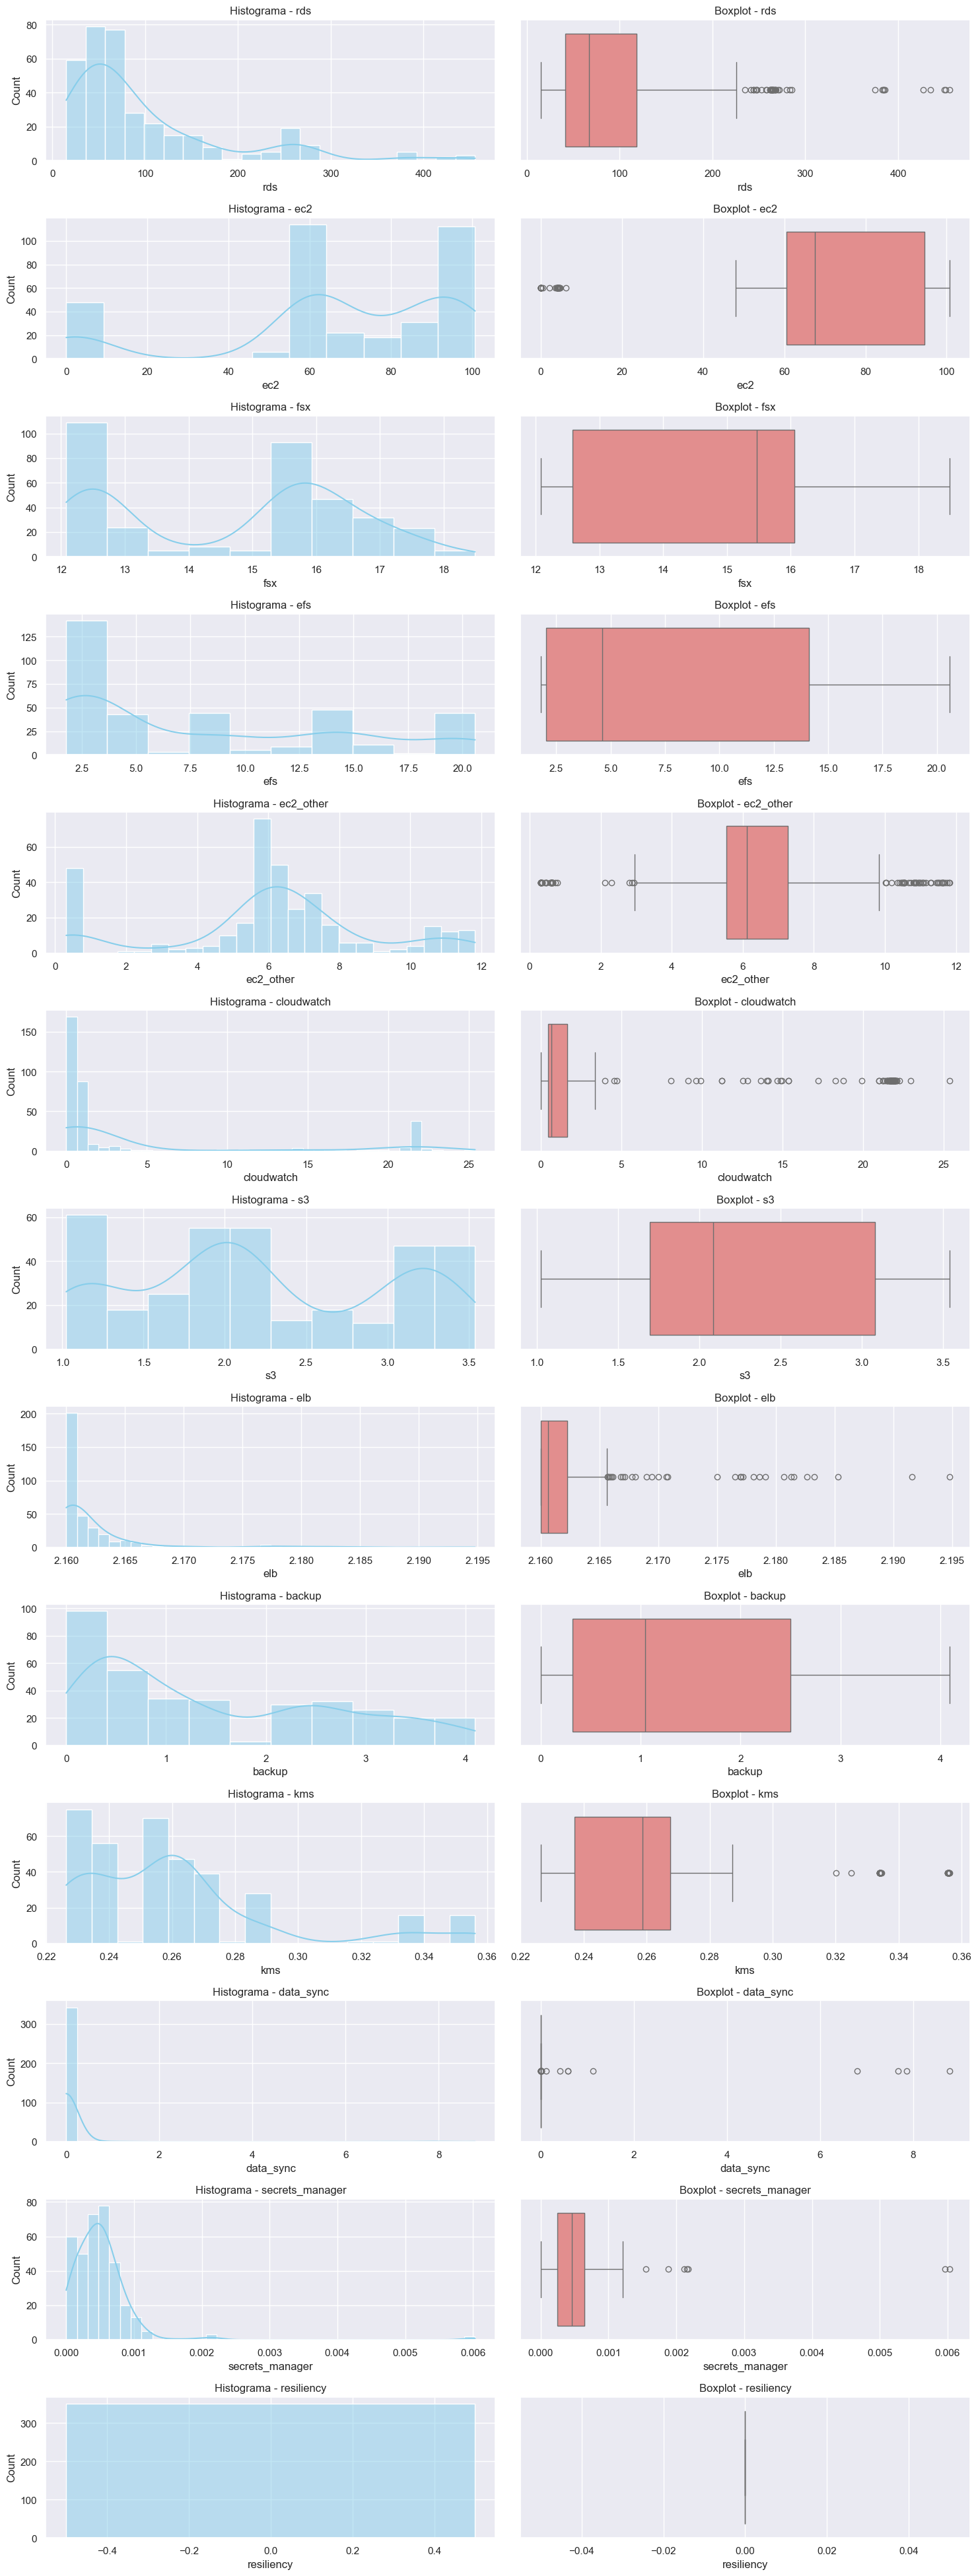

In [67]:

# Visualización: histogramas y boxplots
plt.figure(figsize=(15, len(continuas) * 3))

for i, col in enumerate(continuas):
    plt.subplot(len(continuas), 2, 2*i + 1)
    sns.histplot(continuas[col], kde=True, color='skyblue')
    plt.title(f'Histograma - {col}')
    
    plt.subplot(len(continuas), 2, 2*i + 2)
    sns.boxplot(x=continuas[col], color='lightcoral')
    plt.title(f'Boxplot - {col}')

plt.tight_layout()
plt.show()

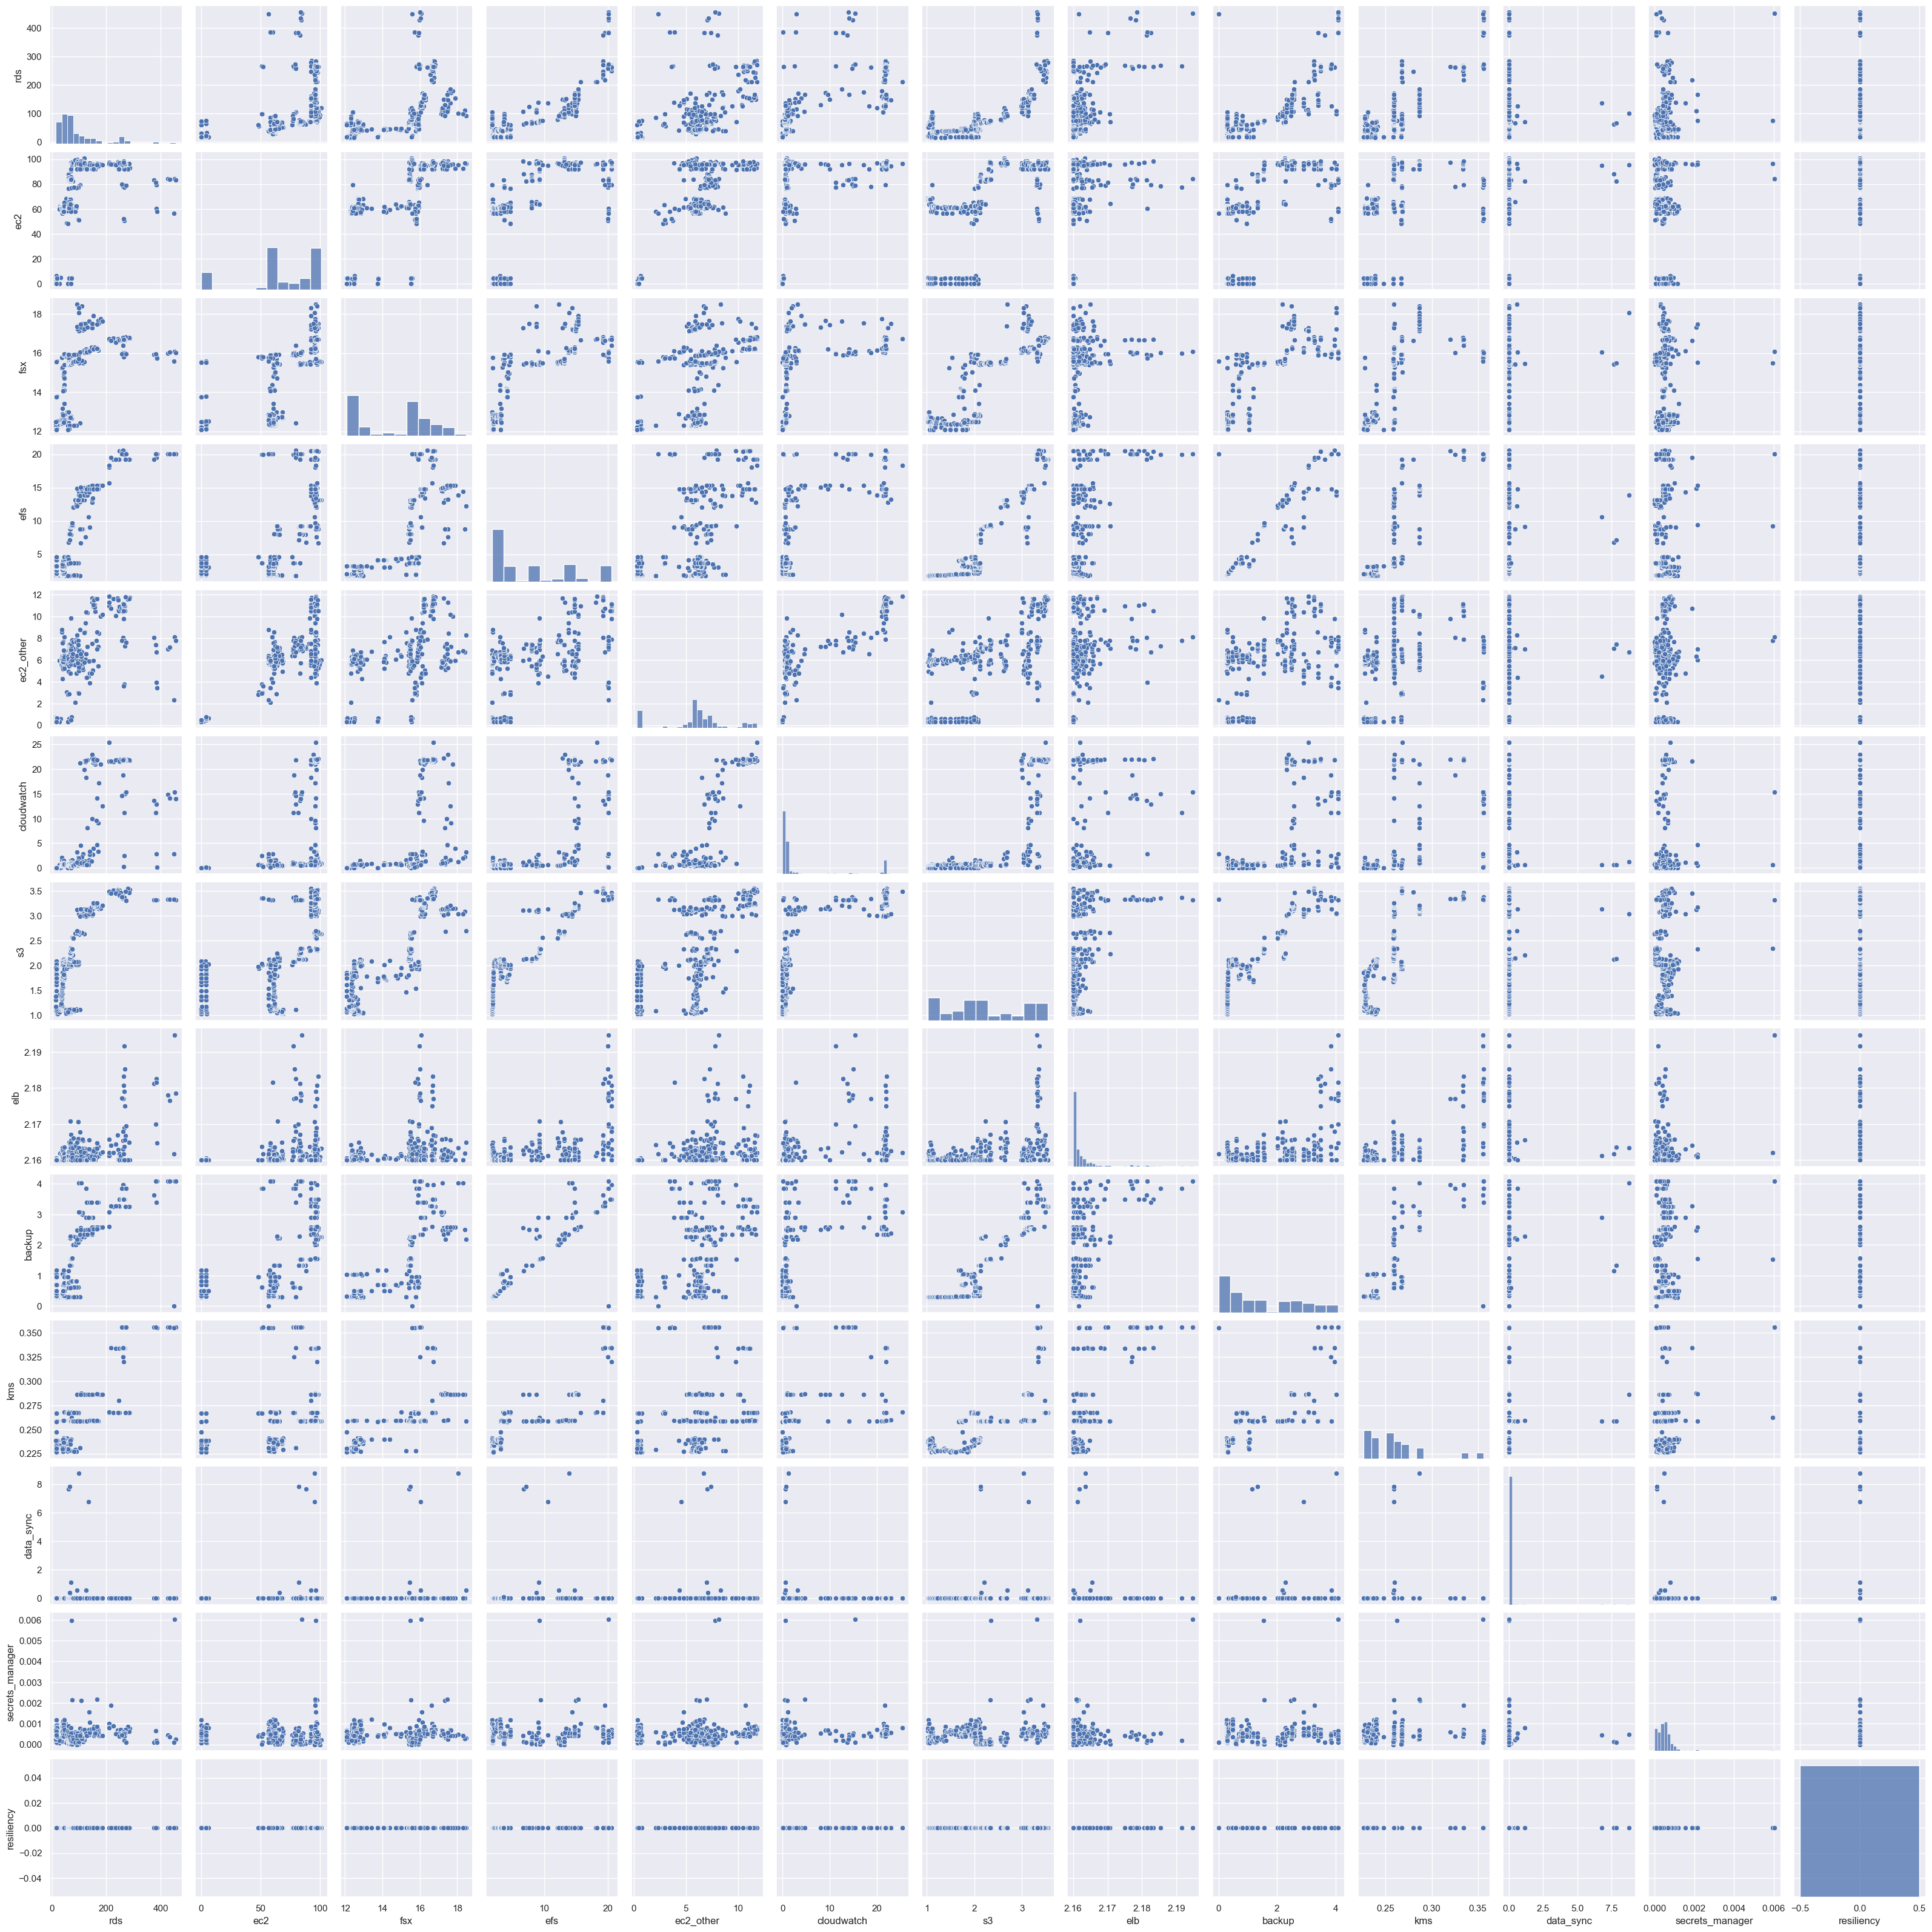

In [68]:
#Gráfico exploratorio por pares de variables
sns.pairplot(continuas);

In [69]:
#La matriz de correlaciones
correlation_matrix=continuas.corr()
continuas.corr();

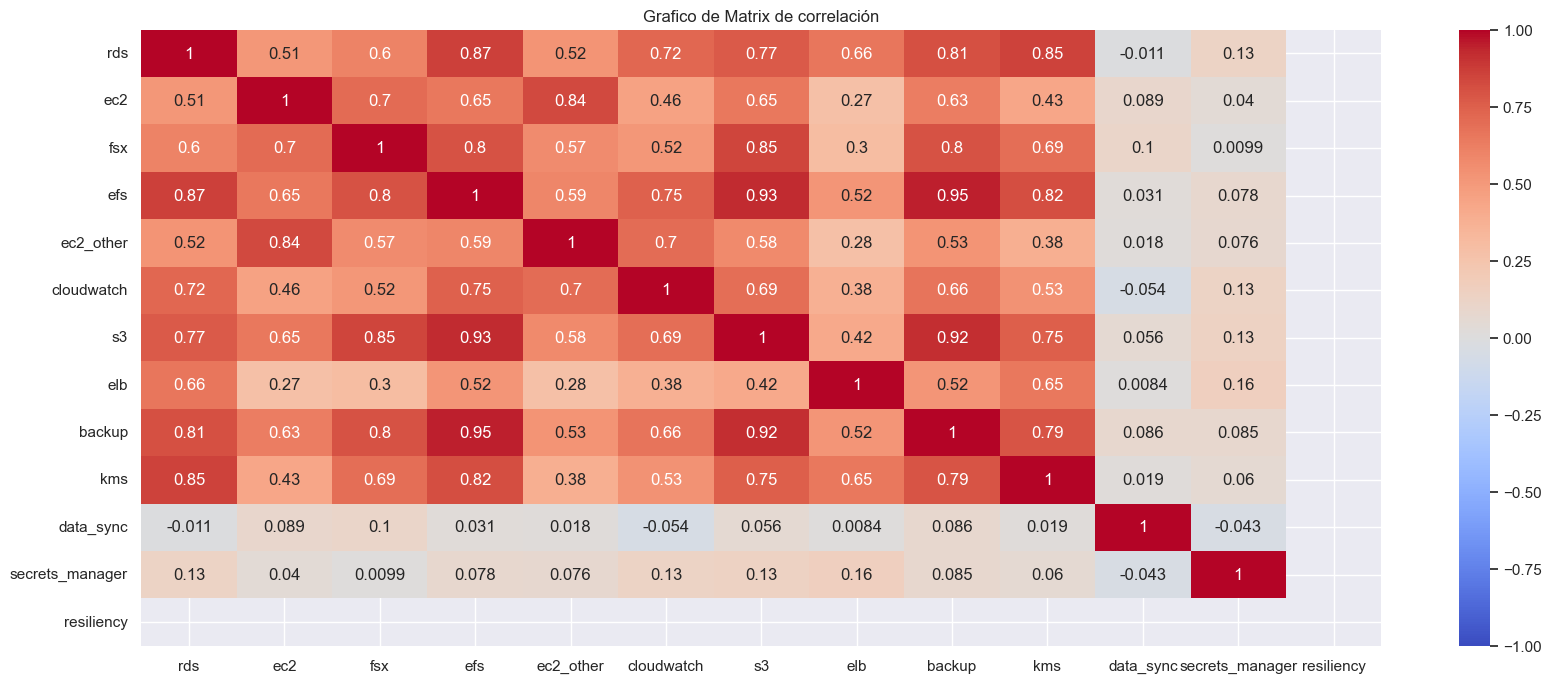

In [70]:
plt.figure(figsize=(20, 8))
ax = sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm",center=0, vmin=-1, vmax=1);
ax.set_title("Grafico de Matrix de correlación")
plt.show()


#Insights del EDA (Vino Blanco)

Para el caso de el dataset , el de vino blanco es significativamente más grande que el de vino tinto por lo que orientamos nuestro modelo solo a tomar la base de Vino blanco de ahroa en adelante, despues del análisis exploratorio de los datos nuestras conclusiones son teniendo en cuenta que nuestra variable objetivo es quality:

1)	La correlación de quality con la varible alcohol es   Positiva Fuerte Es la característica con mas correlacion. A mayor contenido de alcohol, mayor es la puntuación de calidad percibida.
2)	La correlación con volatile acidity Negativa Fuerte siendo la segunda variable más importante. Un aumento en la acidez volátil (sabor a vinagre) reduce drásticamente la calidad.
3)	La density es Negativa media, ósea a Vinos más ligeros (menor densidad) tienden a tener mejor calidad.
4)	La varible residual sugar Positiva media, y quiere decir que  influye positivamente en el vino blanco (donde los sabores más dulces son comunes), a diferencia del tinto.


##Distribucion de la variable Quality :

•	La distribución de la variable quality (objetivo) está muy concentrada en las puntuaciones 6 y 5.
•	Hay muy pocas instancias de vinos de muy baja calidad (3) o muy alta calidad (9). Esto significa que el modelo tendrá dificultades para predecir estos valores extremos y se centrará en el rango medio.

##Escalado :

Debido a que los valores de las varibles tienes valores diferentes por ejemplo Alcohol y PH debemos escalar el dataset.
